# Conceptual Integrity Analysis

## Introduction
This notebook applies *software archaeology techniques* to assess the **conceptual integrity** of a legacy or existing codebase. It helps uncover how well the actual implementation aligns with intended architectural and domain-level concepts — revealing the underlying structure beneath the surface.

### Approach

1. **Conceptual Map (Typology)**
   We start with a `concepts.yaml` file — our catalog of expected *technical* (e.g., Entity, Gateway, Interactor) and *business* (e.g., User, Order, Product) concepts. Each concept comes with a description, rationale, and file pattern hints (`file_globs`) — our typological schema.

2. **Excavation & Mapping**
   The codebase is scanned to locate artifacts (files) matching these patterns. We also detect *outliers* — files that don’t clearly belong to any known conceptual group.

3. **AI-Based Interpretation**
   A Large Language Model (LLM) examines the source code in context and evaluates how well each file reflects its assigned concept. It uses a structured prompt and responds with a confidence score (0.0 to 1.0) — helping us detect weak or partial conceptual alignment.

4. **Topological Visualization**
   The results are visualized as interactive treemaps and summary plots. These diagrams expose:

   * **Well-sorted clusters** of cohesive concept groups
   * **Cross-contamination** between architectural layers
   * **Conceptual voids** and **code graves**
   * Potential signs of **architectural drift**

### Outcome
This AI-supported exploration equips you to:

* Reveal implicit structures buried in legacy code
* Understand how your system has evolved over time
* Identify candidates for refactoring or clarification
* Lay a solid foundation for thoughtful modernization

## 1. Imports and Setup

This section imports the necessary Python libraries for the analysis. We use standard libraries for file operations, data handling (pandas), plotting (Matplotlib, Seaborn, Plotly), and interacting with the OpenAI API.

In [1]:
# --- Standard Library ---
import os                        # File and directory operations
import glob                      # Pattern matching for file paths
from pathlib import Path         # Object-oriented filesystem paths
from collections import defaultdict  # Simplified dict with default values
import fnmatch                   # for filtering on existing lists

# --- Data Handling & Structures ---
import yaml                      # YAML file loading
import numpy as np               # Numerical arrays and math
import pandas as pd              # DataFrames and data analysis

# --- Plotting ---
import matplotlib.pyplot as plt  # Basic plotting
import seaborn as sns            # Statistical plots built on top of matplotlib
import plotly.express as px              # High-level plotting API
import plotly.graph_objects as go        # Low-level figure components
from plotly.subplots import make_subplots  # Subplot layout management

# --- OpenAI API ---
from openai import OpenAI        # LLM-based concept scoring (custom client assumed)

# --- Jupyter Notebook Utilities ---
from IPython.display import display, update_display  # Dynamic output updates
from tqdm.notebook import tqdm   # Interactive progress bars in notebooks

## 2. Configuration

### 2.1 Project information
Here, we set up the core parameters for the analysis.

- `BASE_PATH`: The root directory of the source code we want to analyze.
- `CONCEPTS_FILE_PATH`: The path to the YAML file where our business and technical concepts are defined.
- `PROD_CODE_GLOB`: A programming language and platform dependent filter. Here, we specifically target the `src/main/java` directory, which is the standard for Maven projects.
- `PROD_CODE_EXT`: The file extension of the relevant source code.
- `FILE_FILTER_LIST`: A list of file names that are filtered out of the assessed files. Here, we exclude `package-info.java` files as they don't contain implementation logic but just information about the current Java package.
- `PROJECT_NAME`: The name of the project, extracted from the base path. This is used for labeling outputs.
- `MODEL`: The identifier for the Large Language Model (LLM) we will use for the assessment. This example uses a model available through the OpenRouter API.

Regarding the concepts file: this work must be done in a previous step. Use e.g. the following prompt to get a base line for your software system:

```
Analyze the production Java code in this codebase and extract distinct concepts. Categorize them into two groups:
- technical_concepts: architectural patterns, design tactics, or technical structures
- business_concepts: domain-relevant ideas, rules, or terms that represent key business logic
For each concept, provide:
- name: a short, descriptive name
- explanation: a concise description of what the concept is
- rationale: why this concept likely exists in the codebase (technical or domain motivation)
- file_globs: glob-style patterns of the used naming conventions to identify where this concept appears in the codebase (e.g., **/**Service.java, **/invoicing/**.java)
Output the result as a well-structured YAML file with two top-level sections: technical_concepts and business_concepts. Focus only on Java production code (exclude test files, scripts, and configuration files).
```

You need then to revise the output or (especially for larger software) need to execute some advanced analyses to get these data.

In [2]:
BASE_PATH = "../../../dropover-at/"
PROD_CODE_GLOB = "**/src/main/java/"
PROD_CODE_EXT = ".java"
FILE_FILTER_LIST = ["package-info.java"]
CONCEPTS_FILE_PATH=os.path.join(BASE_PATH, "concepts.yaml")
PROJECT_NAME = BASE_PATH.split(os.sep)[-2]
MODEL="google/gemini-2.5-flash"

### 2.2 LLM setup
An instance of the OpenAI client, configured to point to the OpenRouter API endpoint. You could even use Ollama with Local LLMs here!

In [3]:
client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("OPENROUTER_API_KEY")
)

## 3. Load Concepts and Source Files

Now, we load the necessary data for our analysis:
1.  **Concepts:** We parse the `concepts.yaml` file to get the definitions, descriptions, and file patterns for both business and technical concepts.
2.  **Source Files:** We find all production Java source files (`*.java`) within the project.

In [4]:
concepts_data = {}

with open(CONCEPTS_FILE_PATH, 'r') as file:
    concepts_data =  yaml.safe_load(file)

print("Loaded")
for concept_type in concepts_data.keys():
    print(f"- {len(concepts_data.get(concept_type, []))} {concept_type.replace("_", " ")}")
print(f"for project {PROJECT_NAME}")

# this is a Maven project, so prod files are in a specific directory
all_files = glob.glob(BASE_PATH + PROD_CODE_GLOB + "**/*" + PROD_CODE_EXT, recursive=True)
# remove the info files for packages
all_files = [file for file in all_files if not any(substring in file for substring in FILE_FILTER_LIST)]
print(f"Total source code files: {len(all_files)}")

Loaded
- 11 technical concepts
- 7 business concepts
for project dropover-at
Total source code files: 214


## 4. Concept-to-File Mapping

Here, we map the concepts to the source code files using the provided glob patterns in the concepts file.

- **Matching:** We iterate through each concept and use its `file_globs` patterns to find all matching files in the codebase. This gives us a dictionary where each concept maps to a list of files that are *supposed* to represent it.
- **Statistics:** We print statistics on how many files are associated with each concept. This gives a first impression of the conceptual footprint in the code.
- **Unmatched Files:** Crucially, we also identify the set of Java files that do **not** match any of the defined concepts. These are "rogue" files that may represent hidden or undocumented concepts, or simply code that lacks a clear architectural role.

In [5]:
matched_files_dict = {}

for concept_type in concepts_data.keys():
    matched_files_dict[concept_type] = {}
    concepts = concepts_data.get(concept_type, [])

    for concept in concepts:
        concept_name = concept.get('name')
        files = []

        for pattern in concept.get('file_globs', []):
            pattern = f"{PROD_CODE_GLOB.rstrip('/')}/{pattern.lstrip('/')}"
            matching_files = fnmatch.filter(all_files, pattern)
            files.extend(matching_files)

        matched_files_dict[concept_type][concept_name] = list(set(files))  # remove duplicates

# Print statistics
print("Matched Files Statistics:\n")
total_concepts = 0
total_files = set()

for concept_type, concepts in matched_files_dict.items():
    print(f"{concept_type}:")
    print(f"  Concepts: {len(concepts)}")
    concept_file_counts = [len(files) for files in concepts.values()]
    for concept_name, files in concepts.items():
        print(f"    {concept_name}: {len(files)} file(s)")
        total_files.update(files)
    total_concepts += len(concepts)

matched_files = set()
for type_dict in matched_files_dict.values():
    for file_list in type_dict.values():
        matched_files.update(file_list)
        
unmatched_files = set(all_files) - matched_files
print(f"\nFiles NOT matching any concept: {len(unmatched_files)}")

Matched Files Statistics:

technical_concepts:
  Concepts: 11
    Boundary: 66 file(s)
    Interactor: 45 file(s)
    Entity: 62 file(s)
    Gateway: 17 file(s)
    Delivery: 19 file(s)
    RESTful API: 15 file(s)
    Dependency Injection: 1 file(s)
    Request Model: 30 file(s)
    Response Model: 22 file(s)
    POJO Entities: 10 file(s)
    Validation: 8 file(s)
business_concepts:
  Concepts: 7
    Site: 23 file(s)
    Comment: 28 file(s)
    Creator: 9 file(s)
    File: 22 file(s)
    Scheduling: 49 file(s)
    Todo List: 43 file(s)
    Mail Notification: 8 file(s)

Files NOT matching any concept: 14


### Matched vs. Unmatched Code Ratio

This pie chart provides a high-level overview of the codebase's conceptual coverage. It shows the proportion of source code files that were successfully mapped to a known concept versus those that remain uncategorized. A large "unmatched" slice might indicate incomplete concept definitions or significant parts of the system that deviate from the documented architecture. Everything greater than 50 % matched files is already a good start for lager code bases!

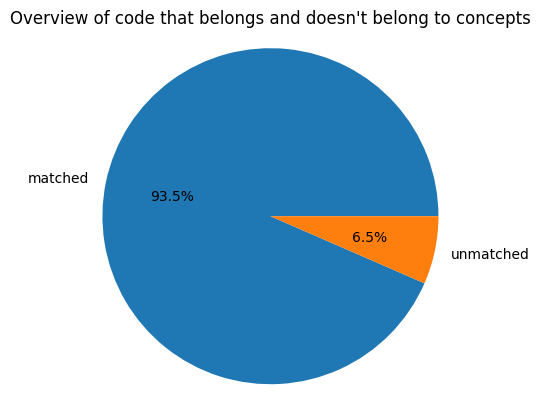

In [6]:
plt.pie(
    [len(matched_files), len(unmatched_files)],
    labels=["matched", "unmatched"],
    autopct='%1.1f%%'
)
plt.title("Overview of code that belongs and doesn't belong to concepts")
plt.axis('equal')  # keep the pie chart as a circle
plt.show()

## 5. LLM-Based Concept Assessment

This is the core of the analysis. We use a Large Language Model (LLM) to act as a software architecture expert and score how well a given source file implements a specific concept.

### 5.1 The Assessment Prompt

The prompt is carefully engineered to get a reliable, structured response from the LLM.

- **Role-Playing:** It instructs the LLM to act as a "software architecture expert."
- **Context:** It provides the `name`, `description`, and `rationale` of the concept, along with the full path and source code.
- **Clear Task:** It asks for a single `confidence score` between 0.0 and 1.0.
- **Constrained Output:** It explicitly requests the format `SCORE: X.X\nEXPLANATION: [text]`, which makes the output easy to parse automatically.
- **Focused Instructions:** It tells the model what to focus on (intent, mechanism, role) and what to ignore (superficial design issues), preventing it from getting sidetracked.

This structured approach is key to turning the qualitative task of code review into a quantitative metric.

*Hint: If your source code files are too large, think about using treesitter to reduce the amount of tokens by using only relevant structural data.*

In [7]:
def create_assessment_prompt(concept, source_code, file_path):
    """Create a prompt for LLM assessment of how well code implements a concept."""
    
    prompt = f"""
    
You are a software architecture expert. Please analyze the following source code and assess how well it implements the specified concept.

CONCEPT TO ASSESS:
Name: {concept['name']}
Description: {concept['description']}
Rationale: {concept['rationale']}

FILE PATH: {file_path}

SOURCE CODE:
{source_code}

Please provide a confidence score between 0.0 and 1.0 that indicates how certain you are that this source code implements the specified concept:
- 0.0 = Definitely does not implement this concept
- 0.5 = Uncertain / partially implements the concept
- 1.0 = Definitely implements this concept

Don't comment on design issues (e.g. lack of encapsulation, code structure quality, etc.) which are here irrelevant for the scoring.

Focus on:
- Whether the concept is meaningfully and recognizably implemented in the code
- Whether its *intent*, *mechanism*, or *role* aligns with the description

Respond with ONLY a single number between 0.1 and 1.0, followed by a brief explanation (max 100 words).

Format: SCORE: X.X\nEXPLANATION: [your explanation]

"""
    
    return prompt

### 5.2 The Assessment functions
Nothing spectacular here to see: These functions handle calling the configured LLM API. They send a prompt with the concept and source code, then extract a numeric confidence score and a short explanation from the LLM’s response. The result gives us something structured we can work with for further analysis.

In [8]:
def assess_concept_implementation(concept, source_code, file_path):
    """Use OpenAI API to assess how well code implements a concept."""
    prompt = create_assessment_prompt(concept, source_code, file_path)
    
    try:
        completion = client.chat.completions.create(
            model=MODEL,
            messages=[{
                "role": "user",
                "content": prompt
            }],
            temperature=0.1
        )

        response_text = completion.choices[0].message.content
        return parse_assessment_response(response_text)

    except Exception as e:
        print(f"Error calling OpenAI API: {e}")
        return 0.0, f"Error: {e}"


def parse_assessment_response(response_text):
    """Extract SCORE and EXPLANATION from LLM response."""
    lines = response_text.split('\n')
    score_line = next((line for line in lines if line.startswith('SCORE:')), '')
    explanation_line = next((line for line in lines if line.startswith('EXPLANATION:')), '')

    # Extract score
    score = 0.0
    if score_line:
        score_str = score_line.replace('SCORE:', '').strip()
        try:
            score = float(score_str)
        except ValueError:
            print(f"Could not parse score: {score_str}")

    # Extract explanation
    explanation = explanation_line.replace('EXPLANATION:', '').strip() if explanation_line else response_text

    return score, explanation

### 5.2 AI Assessment Loop

This function orchestrates the entire assessment process. It iterates through every concept and every file matched to that concept.

For each file, it:
1.  Reads the source code.
2.  Calls the LLM with the assessment prompt.
3.  Parses the `score` and `explanation` from the response.
4.  Stores the results in a list.

**Important Considerations:**
- **Cost and Time:** This process involves making many API calls to an LLM, sending the full source code of each file. This can be **slow and expensive**, especially for large projects.
- **Caching:** For production use, it would be wise to implement a caching mechanism to avoid re-analyzing files that haven't changed.

Finally, the results are compiled into a Pandas DataFrame for further analysis and visualization. We also add a dummy entry for all unmatched files, giving them a score of 0.0.

In [9]:
display_id = "live_output"

def analyze_all_concepts(concepts_data, base_path):
    """Analyze all concepts and their associated files, plus unmatched files."""

    display("Starting ...", display_id=display_id)
    
    # helper for reading source code
    def read_source_code(file_path):
        """Read source code from file."""
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                return file.read()
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
            return ""

    # helper for creating an entry with default information
    def create_base_entry(file_path, concept_type, concept, score, explanation):
        source_code = read_source_code(file_path)
        return {
            'concept_type': concept_type,
            'concept_name': concept.get('name'),
            'concept_description': concept.get('description'),
            'file_path': file_path,
            'file_name': os.path.basename(file_path),
            'score': score,
            'explanation': explanation,
            'code_length': len(source_code)
        }
            
    results = []

    concept_types = concepts_data.keys()
    
    for concept_type in tqdm(concept_types, "Concept Types"):
        concept_type_name = concept_type.replace("_concepts", "")
        
        concepts = concepts_data.get(concept_type, [])
        
        for concept in tqdm(concepts, f"Processing {concept_type_name} concepts"):
            concept_name = concept['name']
            files = matched_files_dict[concept_type][concept_name]
            
            for file_path in tqdm(files, f"Processing files for {concept_name.lower()} concept "):
                source_code = read_source_code(file_path)
                if not source_code:
                    continue
                score, explanation = assess_concept_implementation(concept, source_code, file_path)
                
                entry = create_base_entry(
                    file_path,
                    concept_type_name,
                    concept,
                    score,
                    explanation
                )

                results.append(entry)
                update_display(f"Score for the {concept_type_name} concept {concept_name.lower()} for file {entry['file_name']}: {score}", display_id=display_id)

        # add dummy data for unmatched files
        for file_path in tqdm(unmatched_files, "Matched Files"):
            entry = create_base_entry(file_path, concept_type_name, {'name': None, 'description': None}, 0, "n/a")

    return pd.DataFrame(results)

# Run analysis
results_df = analyze_all_concepts(concepts_data, BASE_PATH)
# add an alternative path for later visualization by concepts and not by file paths
results_df['concept_group'] = results_df['concept_name'] + "/" + results_df['file_name']
results_df.head()

'Score for the business concept mail notification for file EmailChannel.java: 1.0'

Concept Types:   0%|          | 0/2 [00:00<?, ?it/s]

Processing technical concepts:   0%|          | 0/11 [00:00<?, ?it/s]

Processing files for boundary concept :   0%|          | 0/66 [00:00<?, ?it/s]

Processing files for interactor concept :   0%|          | 0/45 [00:00<?, ?it/s]

Processing files for entity concept :   0%|          | 0/62 [00:00<?, ?it/s]

Processing files for gateway concept :   0%|          | 0/17 [00:00<?, ?it/s]

Processing files for delivery concept :   0%|          | 0/19 [00:00<?, ?it/s]

Processing files for restful api concept :   0%|          | 0/15 [00:00<?, ?it/s]

Processing files for dependency injection concept :   0%|          | 0/1 [00:00<?, ?it/s]

Processing files for request model concept :   0%|          | 0/30 [00:00<?, ?it/s]

Processing files for response model concept :   0%|          | 0/22 [00:00<?, ?it/s]

Processing files for pojo entities concept :   0%|          | 0/10 [00:00<?, ?it/s]

Processing files for validation concept :   0%|          | 0/8 [00:00<?, ?it/s]

Matched Files:   0%|          | 0/14 [00:00<?, ?it/s]

Processing business concepts:   0%|          | 0/7 [00:00<?, ?it/s]

Processing files for site concept :   0%|          | 0/23 [00:00<?, ?it/s]

Processing files for comment concept :   0%|          | 0/28 [00:00<?, ?it/s]

Processing files for creator concept :   0%|          | 0/9 [00:00<?, ?it/s]

Processing files for file concept :   0%|          | 0/22 [00:00<?, ?it/s]

Processing files for scheduling concept :   0%|          | 0/49 [00:00<?, ?it/s]

Processing files for todo list concept :   0%|          | 0/43 [00:00<?, ?it/s]

Processing files for mail notification concept :   0%|          | 0/8 [00:00<?, ?it/s]

Matched Files:   0%|          | 0/14 [00:00<?, ?it/s]

,concept_type,concept_name,concept_description,file_path,file_name,score,explanation,code_length,concept_group
0,technical,Boundary,Defines the interfaces for communication betwe...,../../../dropover-at/backend/src/main/java/at/...,AddSchedulingUserResponseModel.java,1.0,This class is explicitly named `AddSchedulingU...,195,Boundary/AddSchedulingUserResponseModel.java
1,technical,Boundary,Defines the interfaces for communication betwe...,../../../dropover-at/backend/src/main/java/at/...,GetTodosRequestModel.java,0.9,This class is explicitly named `GetTodosReques...,175,Boundary/GetTodosRequestModel.java
2,technical,Boundary,Defines the interfaces for communication betwe...,../../../dropover-at/backend/src/main/java/at/...,GetSchedulingResponseModel.java,1.0,This class is explicitly named `GetSchedulingR...,416,Boundary/GetSchedulingResponseModel.java
3,technical,Boundary,Defines the interfaces for communication betwe...,../../../dropover-at/backend/src/main/java/at/...,DeleteSchedulingUserRequestModel.java,1.0,"This code perfectly aligns with the ""Boundary""...",253,Boundary/DeleteSchedulingUserRequestModel.java
4,technical,Boundary,Defines the interfaces for communication betwe...,../../../dropover-at/backend/src/main/java/at/...,GetTodosResponseModel.java,1.0,This class is explicitly named `GetTodosRespon...,214,Boundary/GetTodosResponseModel.java


#### Optional: Save Results

After the time-consuming analysis is complete, it's a good practice to save the results to a CSV file. This allows you to re-run the visualization and statistics steps later without needing to call the LLM again. The filename includes the model and project name for easy identification.

In [10]:
output_filename = f'conceptual_integrity_analysis_results_{MODEL.replace("/","-")}_{PROJECT_NAME}.csv'
results_df.to_csv(output_filename, index=False)
print(f"Complete results (including unmatched files) exported to {output_filename}")
# results_df = pd.read_csv(output_filename, index=False) # uncomment to use already existing data

Complete results (including unmatched files) exported to conceptual_integrity_analysis_results_google-gemini-2.5-flash_dropover-at.csv


## 6. Visualization

Treemaps are an excellent way to visualize hierarchical data, like file systems or conceptual groupings. The area of each rectangle represents the size of the file (in lines of code), and its color represents the LLM's confidence score.

### 6.1 Treemap Helper Functions

These functions prepare the data for the Plotly treemap visualization.

1.  `create_treemap_data`: This is the key function. It takes the results DataFrame and builds the hierarchical structure needed for the treemap. It calculates the size and average score for each directory or concept grouping.
    - It constructs a tree with a root node, intermediate directories (or concepts), and leaf nodes (files).
    - For each node, it computes the total size (sum of lines of code of all children) and the average concept score.
2.  `create_treemap_visualization`: This function takes the prepared data and generates the Plotly figure, configuring the layout, colors, and hover-over information.

*Hint: These functions were vibe-coded by me, and I can’t fully explain it. But it works! What a miracle!*

In [11]:
def normalize_path(path):
    """Normalize file path to remove leading base path prefix."""
    # Remove the common prefix to get relative paths
    if path.startswith(BASE_PATH):
        return path[len(BASE_PATH):]
    return path

def create_treemap_data(df_subset, path_col):
    """Build filesystem hierarchy treemap data."""
    # Normalize paths
    df_subset = df_subset.copy()
    df_subset['normalized_path'] = df_subset[path_col].apply(normalize_path)
    
    # Build directory structure
    directories = set()
    files_data = {}
    
    # Collect all directories and files
    for _, row in df_subset.iterrows():
        path = row['normalized_path']
        path_parts = path.split('/')
        
        # Add all parent directories
        for i in range(1, len(path_parts)):
            dir_path = '/'.join(path_parts[:i])
            if dir_path:
                directories.add(dir_path)
        
        # Store file data
        files_data[path] = row
    
    # Calculate directory sizes (sum of all files in directory and subdirectories)
    dir_sizes = defaultdict(int)
    dir_scores = defaultdict(list)
    dir_file_counts = defaultdict(int)
    
    for file_path, file_data in files_data.items():
        path_parts = file_path.split('/')
        
        # Add file size and score to all parent directories
        for i in range(1, len(path_parts)):
            dir_path = '/'.join(path_parts[:i])
            if dir_path:
                dir_sizes[dir_path] += file_data['code_length']
                dir_scores[dir_path].append(file_data['score'])
                dir_file_counts[dir_path] += 1
    
    # Build treemap data
    ids = []
    labels = []
    parents = []
    values = []
    colors = []
    customdata = []
    
    # Root node
    root_id = "root"
    ids.append(root_id)
    labels.append(f"Project {PROJECT_NAME}")
    parents.append("")
    values.append(df_subset['code_length'].sum())
    colors.append(df_subset['score'].mean())
    customdata.append(
        f"Total files: {len(df_subset)}<br>"
        f"Avg Score: {df_subset['score'].mean():.2f}<br>"
        f"Total Lines: {df_subset['code_length'].sum():,}"
    )
    
    # Add directories
    for dir_path in sorted(directories):
        path_parts = dir_path.split('/')
        dir_name = path_parts[-1]
        
        # Determine parent
        if len(path_parts) == 1:
            parent_id = root_id
        else:
            parent_path = '/'.join(path_parts[:-1])
            parent_id = parent_path
        
        dir_id = dir_path
        avg_score = np.mean(dir_scores[dir_path]) if dir_scores[dir_path] else 0.0
        
        ids.append(dir_id)
        labels.append(dir_name)
        parents.append(parent_id)
        values.append(dir_sizes[dir_path])
        colors.append(avg_score)
        customdata.append(
            f"Directory: {dir_path}<br>"
            f"Files: {dir_file_counts[dir_path]}<br>"
            f"Avg Score: {avg_score:.2f}<br>"
            f"Total Lines: {dir_sizes[dir_path]:,}"
        )
    
    # Add files
    for file_path, file_data in files_data.items():
        path_parts = file_path.split('/')
        file_name = path_parts[-1]
        
        # Determine parent directory
        if len(path_parts) == 1:
            parent_id = root_id
        else:
            parent_dir = '/'.join(path_parts[:-1])
            parent_id = parent_dir
        
        file_id = file_path
        
        # Handle unmatched files (concept_name is NaN)
        if pd.isna(file_data['concept_name']):
            concept_info = "No concept match"
            explanation = file_data['explanation']
        else:
            concept_info = f"Concept: {file_data['concept_name']}"
            explanation = file_data['explanation'][:100] + "..." if len(file_data['explanation']) > 100 else file_data['explanation']
        
        ids.append(file_id)
        labels.append(file_name)
        parents.append(parent_id)
        values.append(file_data['code_length'])
        colors.append(file_data['score'])
        customdata.append(
            f"File: {file_name}<br>"
            f"Score: {file_data['score']:.2f}<br>"
            f"Lines: {file_data['code_length']}<br>"
            f"{concept_info}<br>"
            f"Path: {file_data['file_path']}<br>"
            f"Explanation: {explanation}"
        )
    
    return {
        'ids': ids,
        'labels': labels,
        'parents': parents,
        'values': values,
        'colors': colors,
        'customdata': customdata
    }

In [12]:
def create_treemap_visualization(treemap_data, title, colorscale):
    """Create a Plotly treemap for the given hierarchy."""
    
    fig = go.Figure(go.Treemap(
        ids=treemap_data['ids'],
        labels=treemap_data['labels'],
        parents=treemap_data['parents'],
        values=treemap_data['values'],
        customdata=treemap_data['customdata'],
        hovertemplate='<b>%{label}</b><br>%{customdata}<extra></extra>',
        marker=dict(
            colors=treemap_data['colors'],
            colorscale=colorscale,
            cmin=0,
            cmax=1
        ),
        textinfo="label+value",
        textposition="middle center",
        textfont=dict(size=8),
        branchvalues="total"
    ))
    
    fig.update_layout(
        title={
            'text': title,
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 16}
        },
        margin=dict(t=40, l=10, r=10, b=10),
        width=1920/2,
        height=1080/2
    )
    
    return fig

Helper functions defined.


### 6.2 Treemap Views

We generate two different kinds of treemaps to analyze the results from different perspectives:

1.  **File System-Based View:** This treemap organizes the files according to their actual location in the project's directory structure. This is useful for seeing if conceptual integrity aligns with the physical layout of the code. For example, you might expect all files in a `com.example.gateways` package to have high scores for the "Gateway" concept.
2.  **Concept-Based View:** This treemap ignores the file system and groups files directly under their assigned concepts. This provides a purely logical view of the architecture, making it easy to compare the relative size and implementation quality of different concepts.

#### 6.2.1 Helper Functions
Small helper functions to get rid of repetitive code.

In [13]:
technical_colorscale = [
    (0.0, '#ffffff'),   # White for score 0
    (0.01, '#bfcfd4'),   # bright petrol for score >0
    (1.0, '#004153')    # darker petrol for score 1
]

business_colorscale = [
    (0.0, '#ffffff'),   # White for score 0
    (0.01, '#ffe6d9'),   # bright apricot for score >0
    (1.0, '#ff9c66')    # darker apricot for score 1
]

def save_treemap(fig, concept_type, path):
    output_html_file = f'conceptual_integrity_analysis_visualization_{PROJECT_NAME}_{concept_type}_concepts_{path}_{MODEL.replace("/","-")}.html'
    fig.write_html(output_html_file)
    print(f"Treemap saved as interactive HTML: {output_html_file}")

def create_treemap(results_df, concept_type, path, colorscale):
    data = results_df[results_df['concept_type'] == concept_type]
    treemap_data = create_treemap_data(data, path)
    title = f"Treemap for {concept_type.replace("/", " ")}, {path.replace("_", "")}-based"
    fig = create_treemap_visualization(treemap_data, title, colorscale)
    save_treemap(fig, concept_type, path)
    return fig

#### 6.2.2 File System-Based Views 

Create treemap for technical concepts based on filesystem structure

Treemap saved as interactive HTML: conceptual_integrity_analysis_visualization_dropover-at_technical_concepts_file_path_google-gemini-2.5-flash.html


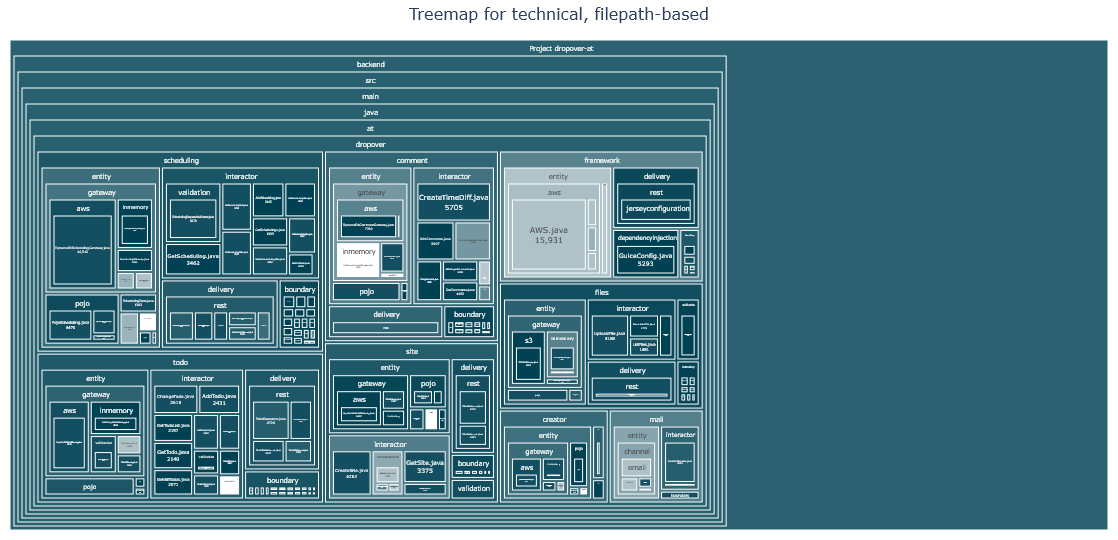

In [14]:
fig = create_treemap(results_df, 'technical', 'file_path', technical_colorscale)
fig.show()

Create treemap for business concepts based on filesystem structure

Treemap saved as interactive HTML: conceptual_integrity_analysis_visualization_dropover-at_business_concepts_file_path_google-gemini-2.5-flash.html


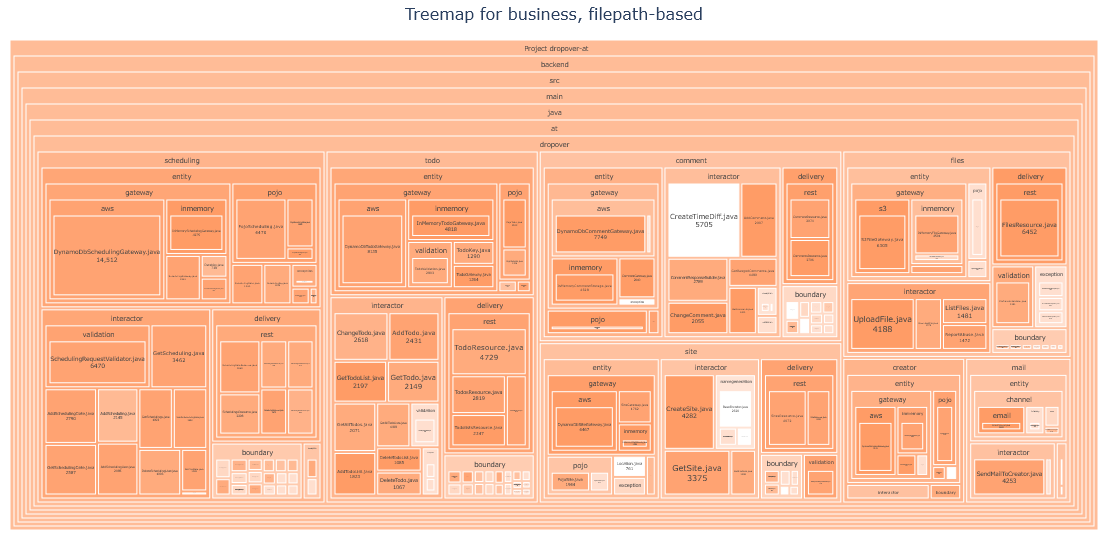

In [19]:
fig = create_treemap(results_df, 'business', 'file_path', business_colorscale)
fig.show()

#### 6.2.3 Concept-Based Views

Create treemap for technical concepts based on concepts

Treemap saved as interactive HTML: conceptual_integrity_analysis_visualization_dropover-at_technical_concepts_concept_group_google-gemini-2.5-flash.html


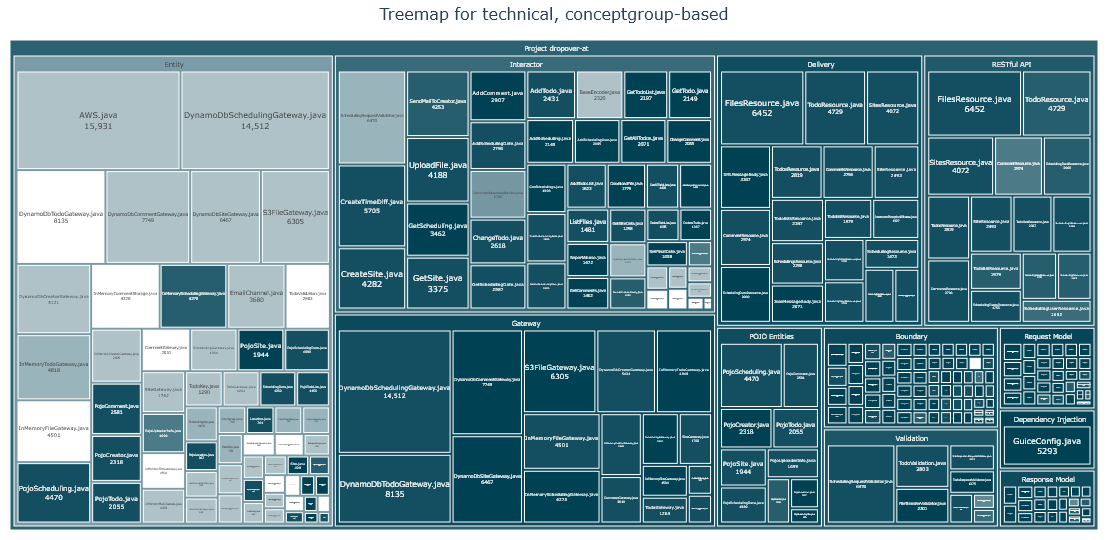

In [20]:
fig = create_treemap(results_df, 'technical', 'concept_group', technical_colorscale)
fig.show()

Create treemap for business concepts based on concepts

Treemap saved as interactive HTML: conceptual_integrity_analysis_visualization_dropover-at_business_concepts_concept_group_google-gemini-2.5-flash.html


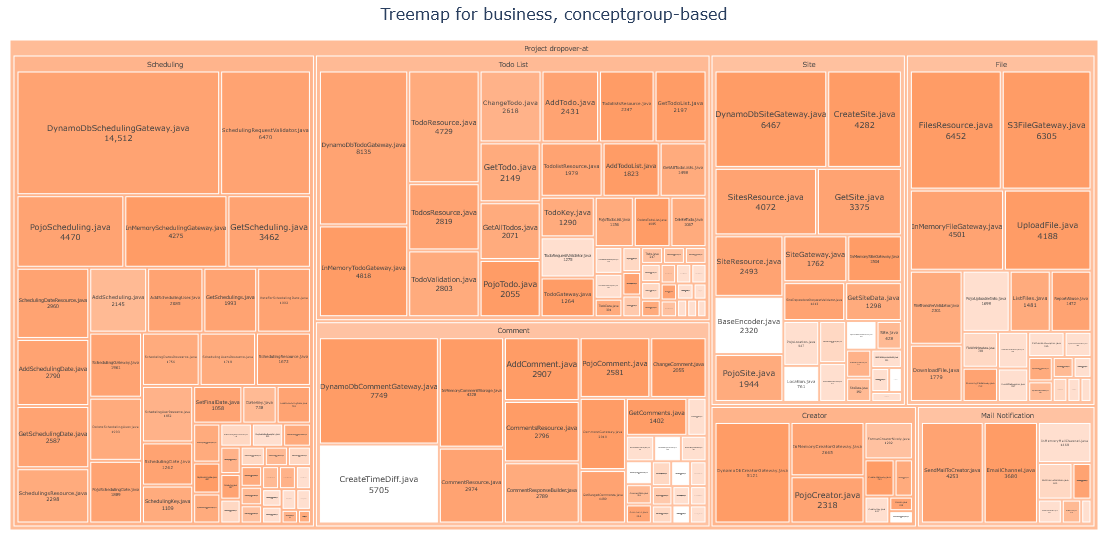

In [21]:
fig = create_treemap(results_df, 'business', 'concept_group', business_colorscale)
fig.show()

## 7. Advanced Statistical Analysis

Beyond the treemaps, we can use standard statistical plots to dig deeper into the results. These plots help us answer more specific questions about the project's conceptual health.

- **Distribution of Scores:** A histogram showing the overall distribution of concept implementation scores. Is it a healthy bell curve, or are scores clustered at the low or high end?
- **Scores by Concept Type:** A box plot comparing the score distributions for *business* vs. *technical* concepts. Is one type of concept implemented more consistently than the other?
- **Matched vs. Unmatched by Type:** A bar chart showing the breakdown of matched and unmatched files for each concept type.
- **Top 10 Concepts by Score:** Which concepts are most successfully implemented across the project?
- **Top 10 Concepts by File Count:** Which concepts have the largest footprint in the codebase?
- **Score Distribution (Matched vs. Unmatched):** This compares the score distribution of files that were matched to a concept against those that weren't (which are all scored at 0). This plot primarily serves as a sanity check.

Hint: This part was ~hallucinated~ created by the LLM in the first draft. I didn’t ask for it, but it looked nice, so I kept it.**

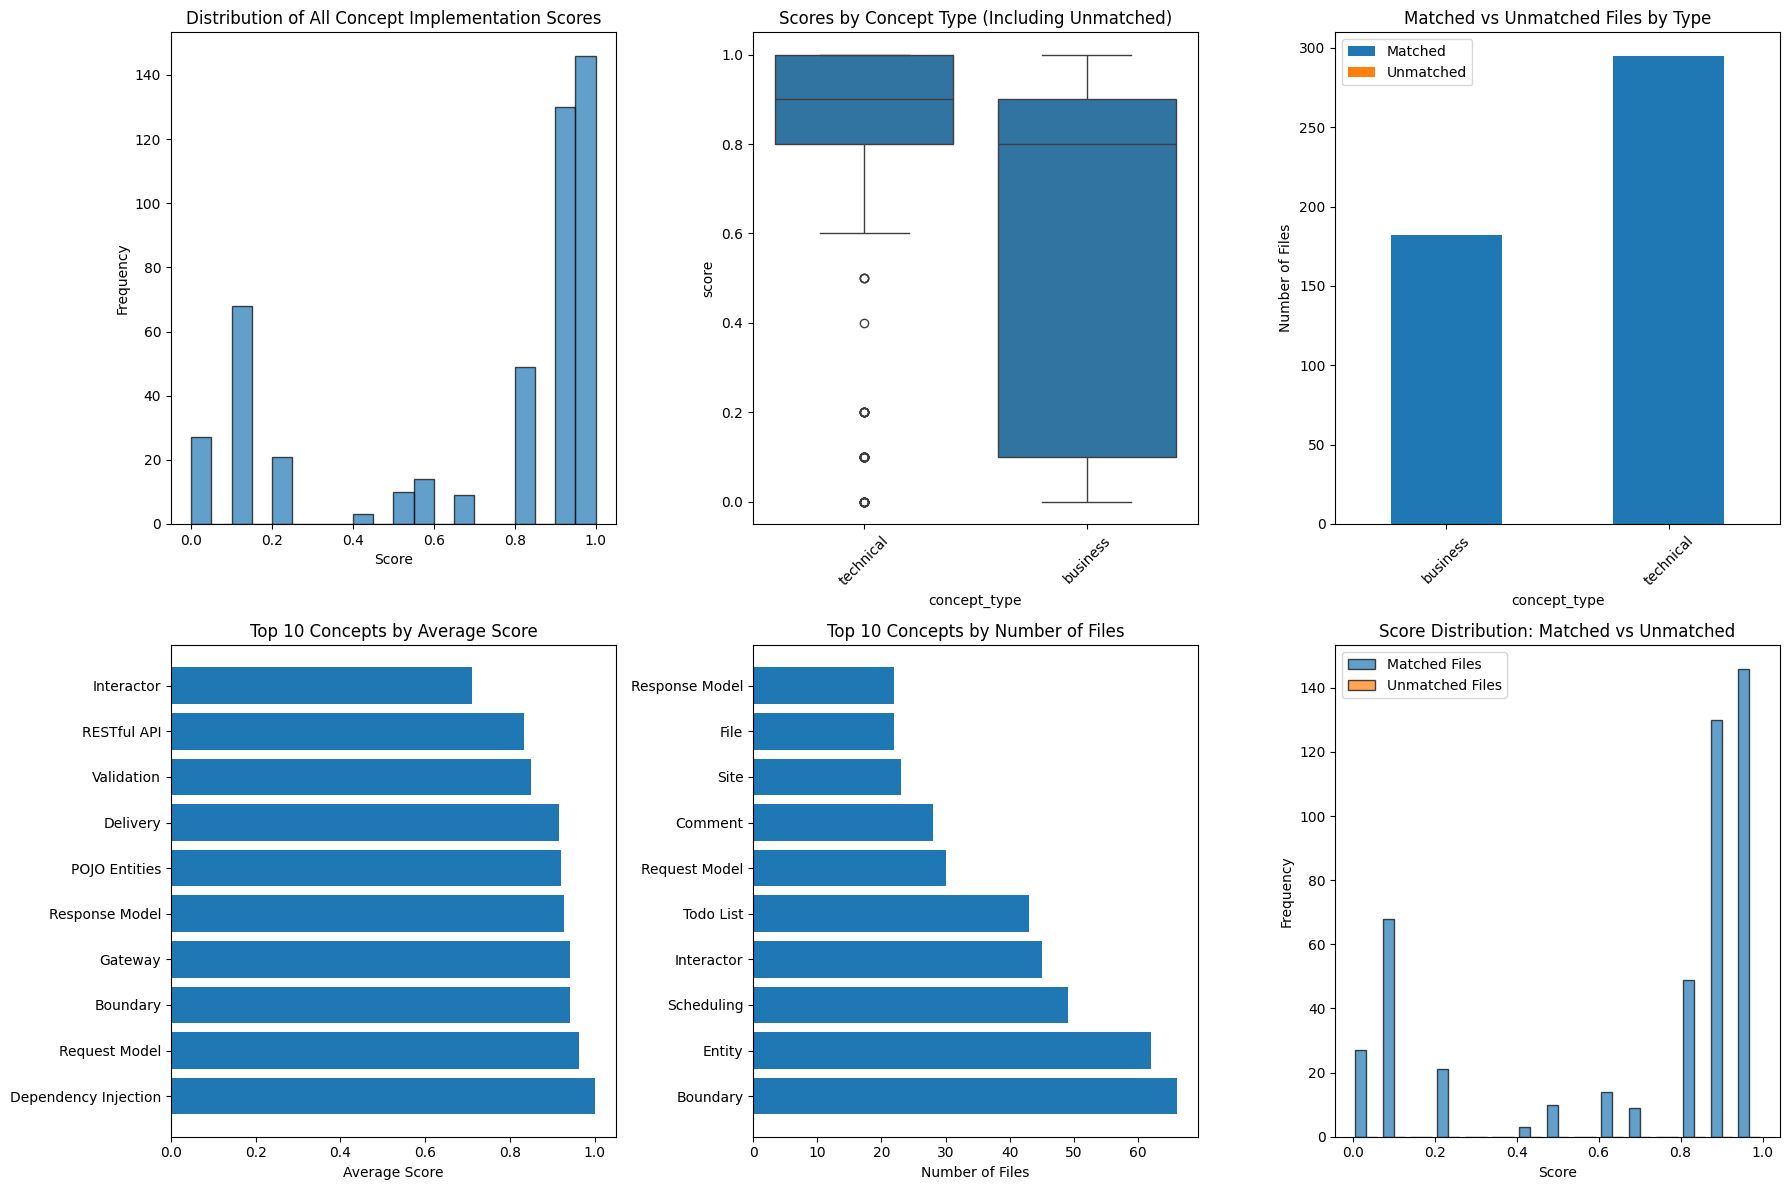

In [18]:
# Enhanced visualizations including unmatched files
if not results_df.empty:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Score distribution
    axes[0, 0].hist(results_df['score'], bins=20, edgecolor='black', alpha=0.7)
    axes[0, 0].set_title('Distribution of All Concept Implementation Scores')
    axes[0, 0].set_xlabel('Score')
    axes[0, 0].set_ylabel('Frequency')
    
    # Scores by concept type
    sns.boxplot(data=results_df, x='concept_type', y='score', ax=axes[0, 1])
    axes[0, 1].set_title('Scores by Concept Type (Including Unmatched)')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Matched vs Unmatched distribution
    matched_counts = results_df.groupby('concept_type').agg({
        'concept_name': lambda x: [x.notna().sum(), x.isna().sum()]
    })['concept_name'].apply(pd.Series)
    matched_counts.columns = ['Matched', 'Unmatched']
    matched_counts.plot(kind='bar', ax=axes[0, 2], stacked=True)
    axes[0, 2].set_title('Matched vs Unmatched Files by Type')
    axes[0, 2].set_ylabel('Number of Files')
    axes[0, 2].tick_params(axis='x', rotation=45)
    
    # Top concepts by average score (excluding unmatched)
    matched_df = results_df[results_df['concept_name'].notna()]
    if not matched_df.empty:
        concept_scores = matched_df.groupby('concept_name')['score'].mean().sort_values(ascending=False).head(10)
        axes[1, 0].barh(concept_scores.index, concept_scores.values)
        axes[1, 0].set_title('Top 10 Concepts by Average Score')
        axes[1, 0].set_xlabel('Average Score')
    
    # Files per concept (excluding unmatched)
    if not matched_df.empty:
        files_per_concept = matched_df.groupby('concept_name').size().sort_values(ascending=False).head(10)
        axes[1, 1].barh(files_per_concept.index, files_per_concept.values)
        axes[1, 1].set_title('Top 10 Concepts by Number of Files')
        axes[1, 1].set_xlabel('Number of Files')
    
    # Score distribution: Matched vs Unmatched
    matched_scores = results_df[results_df['concept_name'].notna()]['score']
    unmatched_scores = results_df[results_df['concept_name'].isna()]['score']
    
    axes[1, 2].hist([matched_scores, unmatched_scores], bins=15, 
                   label=['Matched Files', 'Unmatched Files'], 
                   alpha=0.7, edgecolor='black')
    axes[1, 2].set_title('Score Distribution: Matched vs Unmatched')
    axes[1, 2].set_xlabel('Score')
    axes[1, 2].set_ylabel('Frequency')
    axes[1, 2].legend()
    
    plt.tight_layout()
    plt.show()

## 8. Conclusion

This notebook lets you check the integrity of the concepts in your software system. If you achieve high scores in both concept coverage and concept integrity, you no longer need to know every line of source code by heart but just the core idea behind each file. It's all about understanding the concepts they represent. That’s what enables you to efficiently work with large legacy codebases. Isn’t that nice?

Markus Harrer  
https://markusharrer.de  
July 2025  